In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [17]:
df_result_accuracy = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'accuracy'])
df_result_rmse = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'rmse'])

In [3]:
geo = geo = pd.read_csv('../datasets/hackathon_processed.csv')
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross','Netpay','Porosity','Permeability', 'Depth']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [4]:
geo_train, geo_test = train_test_split(geo, test_size=0.1)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [5]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont'}

In [6]:
geo_signs = get_nodes_sign(geo)
geo_signs

{'Gross': 'pos',
 'Netpay': 'pos',
 'Porosity': 'pos',
 'Permeability': 'pos',
 'Depth': 'pos'}

In [7]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [8]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

# Hill Climbing

# Дискретная структра + смешанные параметры

In [12]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

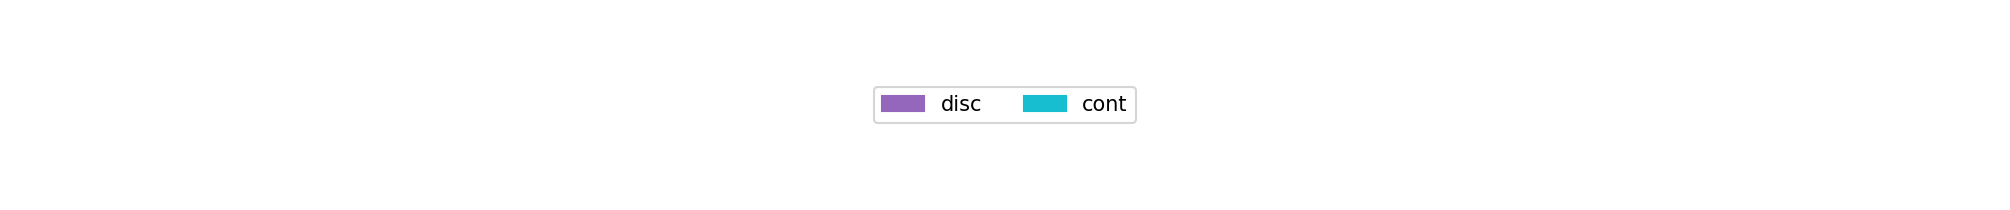

In [13]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [11]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [12]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [13]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

3
6
7
7
11
12
12
13
17
18
21
21
22
22
27
27
29
32
34
35
36
39
42


In [14]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.49,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67}

In [15]:
rmse

{'Gross': 401.61,
 'Netpay': 117.99,
 'Porosity': 4.14,
 'Permeability': 911.97,
 'Depth': 1291.42}

In [16]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

In [17]:
sample_d_m_hc = pd.DataFrame(geo_bn.randomsample(700))
sample_d_m_hc_gross = sample_d_m_hc.loc[sample_d_m_hc['Gross'] > 0]
sample_d_m_hc_netpay = sample_d_m_hc.loc[sample_d_m_hc['Netpay'] > 0]
sample_d_m_hc_porosity = sample_d_m_hc.loc[sample_d_m_hc['Porosity'] > 0]
sample_d_m_hc_permeability = sample_d_m_hc.loc[sample_d_m_hc['Permeability'] > 0]
sample_d_m_hc_depth = sample_d_m_hc.loc[sample_d_m_hc['Depth'] > 0]

# Смешанная структура + смешанные параметры

In [18]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

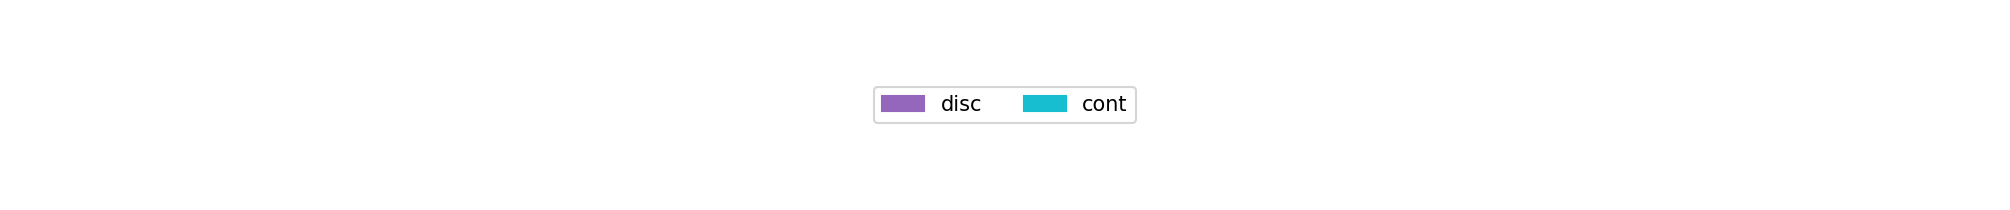

In [19]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [20]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [21]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [22]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

3
3
3
3
3
6
6
6
6
6
7
7
7
7
7
7
12
12
12
12
12
12
13
13
13
13
13
18
18
18
18
18
21
21
21
21
21
21
22
22
22
22
22
26
26
26
26
26
27
27
27
27
27
27
32
32
32
32
32
34
34
34
34
34
36
36
36
36
36
42
42
42
42
42


In [23]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.49,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67}

In [24]:
rmse

{'Gross': 272.7,
 'Netpay': 54.99,
 'Porosity': 4.19,
 'Permeability': 491.92,
 'Depth': 833.04}

In [25]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

In [26]:
sample_m_m_hc = pd.DataFrame(geo_bn.randomsample(700))
sample_m_m_hc_gross = sample_m_m_hc.loc[sample_m_m_hc['Gross'] > 0]
sample_m_m_hc_netpay = sample_m_m_hc.loc[sample_m_m_hc['Netpay'] > 0]
sample_m_m_hc_porosity = sample_m_m_hc.loc[sample_m_m_hc['Porosity'] > 0]
sample_m_m_hc_permeability = sample_m_m_hc.loc[sample_m_m_hc['Permeability'] > 0]
sample_m_m_hc_depth = sample_m_m_hc.loc[sample_m_m_hc['Depth'] > 0]

# Дискретная стурктура + дискретные параметры

In [27]:
geo_new_types = {'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'disc',
 'Netpay': 'disc',
 'Porosity': 'disc',
 'Permeability': 'disc',
 'Depth': 'disc'}

In [28]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_new_types)

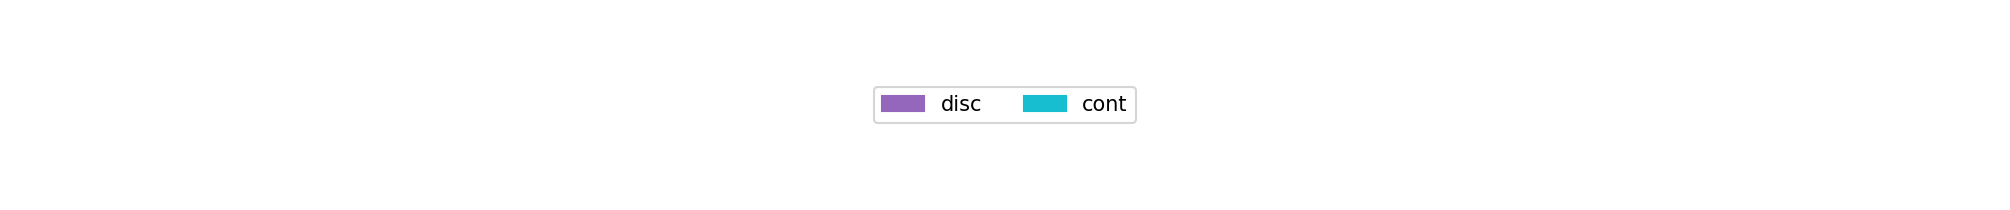

In [29]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [30]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [31]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [32]:
test_discrete = copy(geo_test)

In [33]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [34]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Gross,Netpay,Porosity,Permeability,Depth
0,GRAVITY,JURASSIC,LIMESTONE,SALT,OIL,1,2,4,3,2
1,EXTENSION,NEOGENE,SANDSTONE,RIFT,OIL,4,1,4,4,1
2,COMPRESSION,CRETACEOUS,SANDSTONE,FORELAND,OIL,0,0,3,1,1
3,COMPRESSION,PALEOGENE-NEOGENE,LIMESTONE,FORELAND,OIL,4,4,3,2,0
4,GRAVITY,CRETACEOUS,SANDSTONE,SALT,OIL,2,1,4,4,1
5,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,1,1,4,4,1
6,COMPRESSION,ORDOVICIAN,SANDSTONE,INTRACRATONIC,GAS,4,3,0,0,2
7,EXTENSION,MESOZOIC,VOLCANICS,RIFT,OIL,3,3,1,0,4
8,STRIKE-SLIP,NEOGENE,SANDSTONE,INVERSION,OIL,4,3,3,2,1
9,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,OIL,2,2,3,2,1


In [35]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

7
7
12
12
21
21
22
22
27
27
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar in

In [36]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.47,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [37]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [38]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [39]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [40]:
m = mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [41]:
m = mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [42]:
m = mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [43]:
m = mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [44]:
m = mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [45]:
sample_d_d_hc = pd.DataFrame(geo_bn.randomsample(500))
sample_d_d_hc = inverse_discretization(sample_d_d_hc, columns_for_disc, discrete_coder)

# Смешанная структура + дискретные параметры

In [46]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_new_types)

ed in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (m

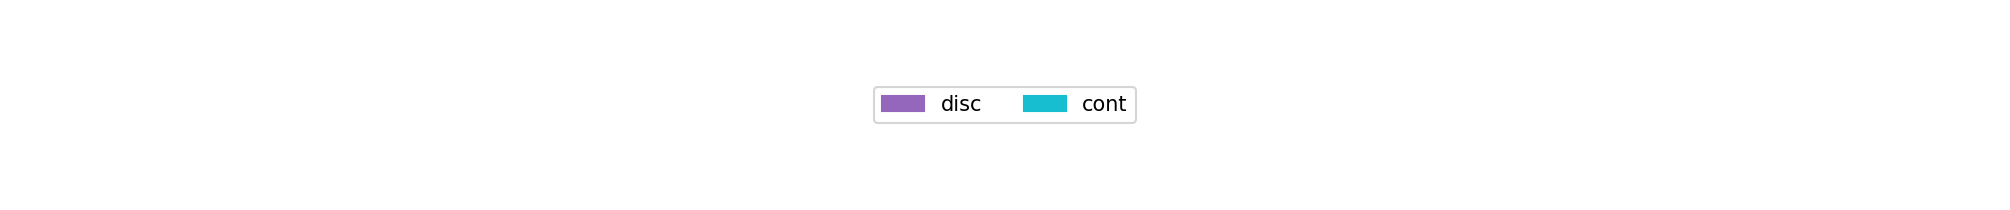

In [47]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [48]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [49]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [50]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

7
7
7
7
7
7
7
12
12
12
12
12
12
12
21
21
21
21
21
21
21
22
22
22
22
22
27
27
27
27
27
27
27
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: F

In [51]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.29,
 'Lithology': 0.56,
 'Structural setting': 0.6,
 'Hydrocarbon type': 0.56,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [52]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [53]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [54]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [55]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [56]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [57]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)

In [58]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [59]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

# EVO

# Дискретная стурктура + смешанные параметры

In [9]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 13.035099999999998
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.0 min
Best metric is 11.2631
Generation num: 1
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 11.2631
Generation num: 2
max_depth: 3, no improvements: 1
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 10.9845
Generation num: 3
max_depth: 3, no improve

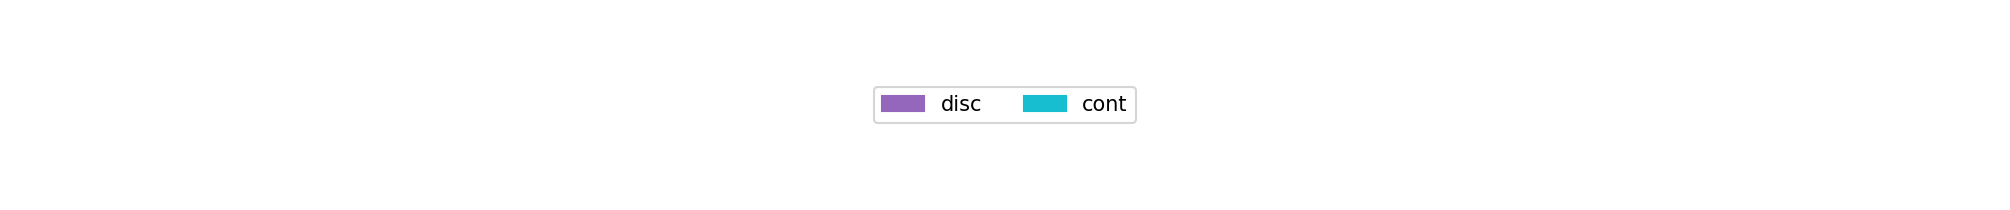

In [10]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [62]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [63]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [64]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

3
7
12
21
22
27
36
36


In [65]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.24,
 'Lithology': 0.51,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67}

In [66]:
rmse

{'Gross': 401.26,
 'Netpay': 117.14,
 'Porosity': 7.63,
 'Permeability': 925.17,
 'Depth': 1362.48}

In [67]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

In [68]:
sample_d_m_evo = pd.DataFrame(geo_bn.randomsample(700))
sample_d_m_evo_gross = sample_d_m_evo.loc[sample_d_m_evo['Gross'] > 0]
sample_d_m_evo_netpay = sample_d_m_evo.loc[sample_d_m_evo['Netpay'] > 0]
sample_d_m_evo_porosity = sample_d_m_evo.loc[sample_d_m_evo['Porosity'] > 0]
sample_d_m_evo_permeability = sample_d_m_evo.loc[sample_d_m_evo['Permeability'] > 0]
sample_d_m_evo_depth = sample_d_m_evo.loc[sample_d_m_evo['Depth'] > 0]

# Смешанная структура + смешанные параметры

In [69]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 28.73551121511904
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 23.012926701008254
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 23.012926701008254
Generation num: 2
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.4 min
Best metric is 22.525296520258955
Generation num: 3
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.4 min
Best metric is 21.508425224799648
Generation num: 4
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.6 min
Best metric is 21.508425224799648
Generation num: 5
max_

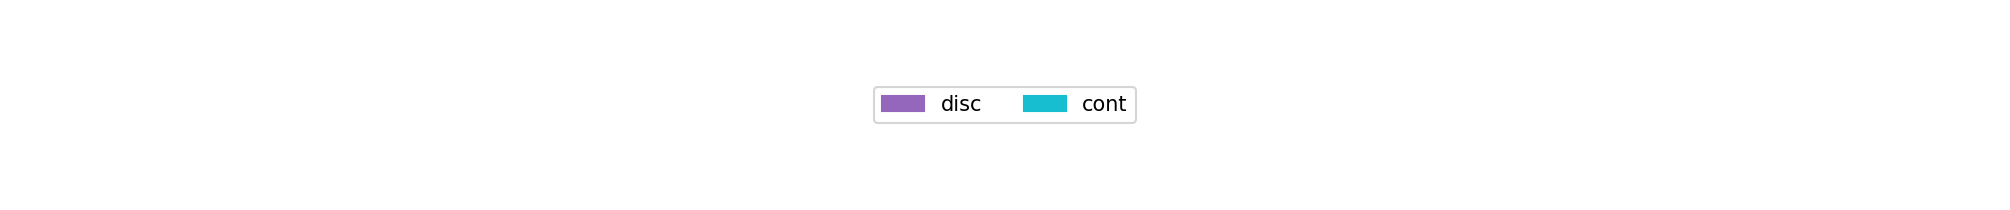

In [70]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [71]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [72]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [73]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

22


In [74]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67}

In [75]:
rmse

{'Gross': 417.59,
 'Netpay': 124.56,
 'Porosity': 5.25,
 'Permeability': 817.91,
 'Depth': 1263.09}

In [76]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

In [77]:
sample_m_m_evo = pd.DataFrame(geo_bn.randomsample(700))
sample_m_m_evo_gross = sample_m_m_evo.loc[sample_m_m_evo['Gross'] > 0]
sample_m_m_evo_netpay = sample_m_m_evo.loc[sample_m_m_evo['Netpay'] > 0]
sample_m_m_evo_porosity = sample_m_m_evo.loc[sample_m_m_evo['Porosity'] > 0]
sample_m_m_evo_permeability = sample_m_m_evo.loc[sample_m_m_evo['Permeability'] > 0]
sample_m_m_evo_depth = sample_m_m_evo.loc[sample_m_m_evo['Depth'] > 0]

# Дискретная структура + дискретные параметры

In [78]:
geo_new_types = {'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'disc',
 'Netpay': 'disc',
 'Porosity': 'disc',
 'Permeability': 'disc',
 'Depth': 'disc'}

In [79]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 12.5674
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.0 min
Best metric is 10.9844
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 10.9844
Generation num: 2
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 10.416700000000002
Generation num: 3
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 10.416700000000002
Generation num: 4
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 m

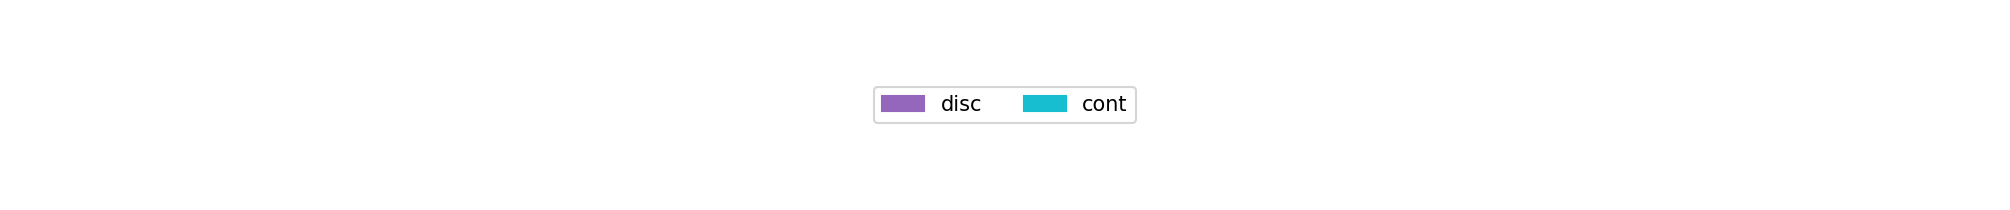

In [80]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [81]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [82]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [83]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [84]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.22,
 'Lithology': 0.51,
 'Structural setting': 0.4,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [85]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [86]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [87]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [88]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [89]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [90]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)


In [91]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [92]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

In [93]:
sample_d_d_evo = pd.DataFrame(geo_bn.randomsample(500))
sample_d_d_evo = inverse_discretization(sample_d_d_evo, columns_for_disc, discrete_coder)

# Смешанная структура + дискретные параметры

In [94]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 24.855200640407677
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 24.855200640407677
Generation num: 1
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.3 min
Best metric is 24.855200640407677
Generation num: 2
max_depth: 3, no improvements: 2
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.5 min
Best metric is 24.80000069178264
Generation num: 3
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.6 min
Best metric is 24.80000069178264
Generation num: 4
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'op

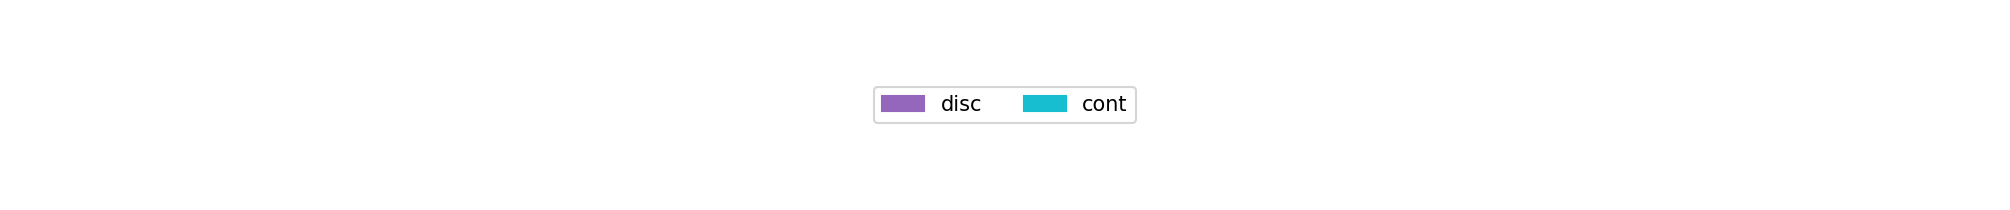

In [95]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [96]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [97]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [98]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

7
12
21
27
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the

In [99]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.64,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [100]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [101]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)


In [102]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [103]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [104]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [105]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)

In [106]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [107]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

In [108]:
df_result_accuracy.to_csv('geo_results_disc.csv', index=False)
df_result_rmse.to_csv('geo_results_cont.csv', index=False)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

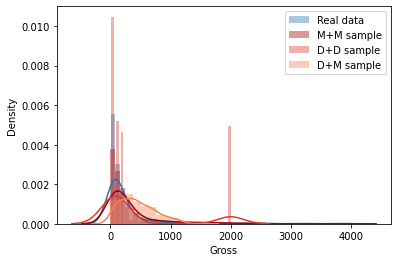

In [109]:
sns.distplot(geo['Gross'], label = 'Real data')
sns.distplot(sample_m_m_hc_gross['Gross'], label = 'M+M sample', color=sns.color_palette("OrRd", 10)[9])
sns.distplot(sample_d_d_hc['Gross'], label='D+D sample', color=sns.color_palette("OrRd", 10)[7])
sns.distplot(sample_d_m_hc_gross['Gross'], label='D+M sample', color=sns.color_palette("OrRd", 10)[5])
plt.legend()

In [110]:
stats.anderson(sample_m_m_hc_gross['Gross'].values, 'extreme1')

AndersonResult(statistic=74.25747643708837, critical_values=array([0.469, 0.631, 0.75 , 0.868, 1.028]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]))

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

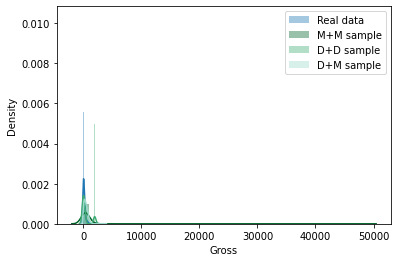

In [111]:
sns.distplot(geo['Gross'], label = 'Real data')
sns.distplot(sample_m_m_evo_gross['Gross'], label = 'M+M sample', color=sns.color_palette("BuGn", 10)[9])
sns.distplot(sample_d_d_evo['Gross'], label='D+D sample', color=sns.color_palette("BuGn", 10)[6])
sns.distplot(sample_d_m_evo_gross['Gross'], label='D+M sample', color=sns.color_palette("BuGn", 10)[3])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

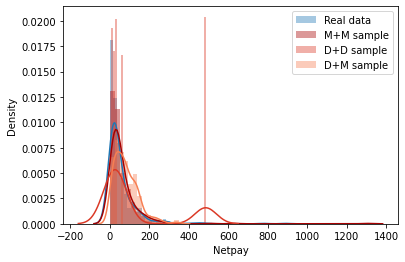

In [112]:
sns.distplot(geo['Netpay'], label = 'Real data')
sns.distplot(sample_m_m_hc_netpay['Netpay'], label = 'M+M sample', color=sns.color_palette("OrRd", 10)[9])
sns.distplot(sample_d_d_hc['Netpay'], label='D+D sample', color=sns.color_palette("OrRd", 10)[7])
sns.distplot(sample_d_m_hc_netpay['Netpay'], label='D+M sample', color=sns.color_palette("OrRd", 10)[5])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

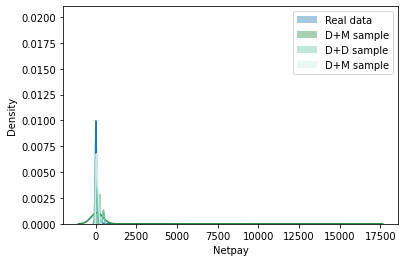

In [113]:
sns.distplot(geo['Netpay'], label = 'Real data')
sns.distplot(sample_d_m_evo_netpay['Netpay'], label = 'D+M sample', color=sns.color_palette("BuGn", 3)[2])
sns.distplot(sample_d_d_evo['Netpay'], label='D+D sample', color=sns.color_palette("BuGn", 3)[1])
sns.distplot(sample_m_m_evo_netpay['Netpay'], label='D+M sample', color=sns.color_palette("BuGn",3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

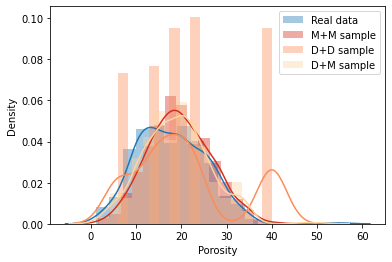

In [114]:
sns.distplot(geo['Porosity'], label = 'Real data')
sns.distplot(sample_m_m_hc_porosity['Porosity'], label = 'M+M sample', color=sns.color_palette("OrRd", 3)[2])
sns.distplot(sample_d_d_hc['Porosity'], label='D+D sample', color=sns.color_palette("OrRd", 3)[1])
sns.distplot(sample_d_m_hc_porosity['Porosity'], label='D+M sample', color=sns.color_palette("OrRd", 3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

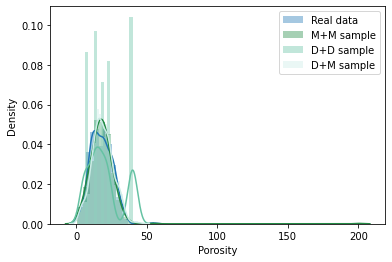

In [115]:
sns.distplot(geo['Porosity'], label = 'Real data')
sns.distplot(sample_m_m_evo_porosity['Porosity'], label = 'M+M sample', color=sns.color_palette("BuGn", 3)[2])
sns.distplot(sample_d_d_evo['Porosity'], label='D+D sample', color=sns.color_palette("BuGn", 3)[1])
sns.distplot(sample_d_m_evo_porosity['Porosity'], label='D+M sample', color=sns.color_palette("BuGn", 3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

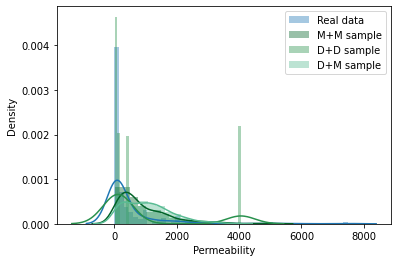

In [116]:
sns.distplot(geo['Permeability'], label = 'Real data')
sns.distplot(sample_m_m_evo_permeability['Permeability'], label = 'M+M sample', color=sns.color_palette("BuGn", 10)[9])
sns.distplot(sample_d_d_evo['Permeability'], label='D+D sample', color=sns.color_palette("BuGn", 10)[7])
sns.distplot(sample_d_m_evo_permeability['Permeability'], label='D+M sample', color=sns.color_palette("BuGn", 10)[5])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

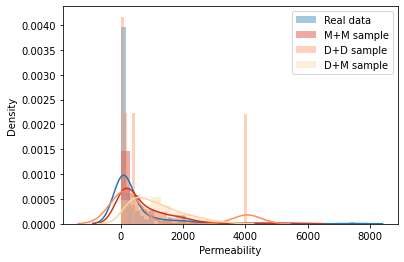

In [117]:
sns.distplot(geo['Permeability'], label = 'Real data')
sns.distplot(sample_m_m_hc_permeability['Permeability'], label = 'M+M sample', color=sns.color_palette("OrRd", 3)[2])
sns.distplot(sample_d_d_hc['Permeability'], label='D+D sample', color=sns.color_palette("OrRd", 3)[1])
sns.distplot(sample_d_m_hc_permeability['Permeability'], label='D+M sample', color=sns.color_palette("OrRd", 3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

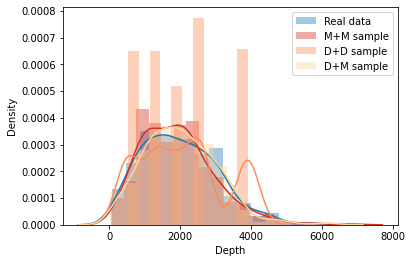

In [118]:
sns.distplot(geo['Depth'], label = 'Real data')
sns.distplot(sample_m_m_hc_depth['Depth'], label = 'M+M sample', color=sns.color_palette("OrRd", 3)[2])
sns.distplot(sample_d_d_hc['Depth'], label='D+D sample', color=sns.color_palette("OrRd", 3)[1])
sns.distplot(sample_d_m_hc_depth['Depth'], label='D+M sample', color=sns.color_palette("OrRd", 3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

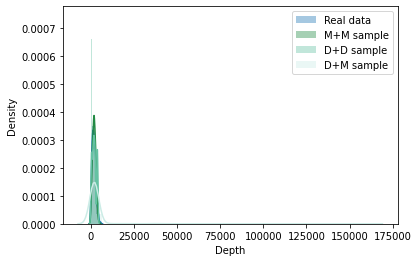

In [119]:
sns.distplot(geo['Depth'], label = 'Real data')
sns.distplot(sample_m_m_evo_depth['Depth'], label = 'M+M sample', color=sns.color_palette("BuGn", 3)[2])
sns.distplot(sample_d_d_evo['Depth'], label='D+D sample', color=sns.color_palette("BuGn", 3)[1])
sns.distplot(sample_d_m_evo_depth['Depth'], label='D+M sample', color=sns.color_palette("BuGn", 3)[0])
plt.legend()

In [126]:
geo_sample = geo.sample(331)

In [130]:
sample_d_d_hc = sample_d_d_hc.sample(442)

In [122]:
from scipy.spatial import distance

distance.jensenshannon(geo_sample['Gross'].values, sample_m_m_hc_gross['Gross'].values)

0.5428559364675586

In [127]:
distance.jensenshannon(geo_sample['Gross'].values, sample_d_m_hc_gross['Gross'].values)

0.4688016521750214

In [133]:
sample_d_d_hc['Gross'] = sample_d_d_hc['Gross'].apply(lambda x: float(x))

In [134]:
distance.jensenshannon(geo['Gross'].values, sample_d_d_hc['Gross'].values)

0.5684313318326214